In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.inspection import partial_dependence
from IncrementsRegression import model

In [44]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
BASEPATH = 'C:/SuryaMain/Python Projects/ChinookUL/ChinookGrowthProject'
SIMULATION_BASEPATH = os.path.join(BASEPATH, "simulate_nonlinear_data")

In [12]:
class RFRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, params = None):
        self.hparams = params
        self.model = RandomForestRegressor(**self.hparams)
        self.rsquared = None
        self.istrained = False

    def fit(self, X_train, y_train):
        self.model.fit(X_train,y_train)
        self.rsquared = self.model.score(X_train,y_train)
        self.istrained = True

    def predict(self, X, y=None):
        pred = self.model.predict(X)
        if y is not None:
            self.rsquared = r2_score(y, pred)
        return pred
    
    def get_rsquared(self):
        return self.rsquared;
    
    def get_istrained(self):
        return self.istrained;

In [13]:
def train_sim_model(params = {"n_estimators": 100, "oob_score":True, "min_impurity_decrease":0.1}, data_path = os.path.join(SIMULATION_BASEPATH, 'data_set_1')):
    X = pd.read_csv(os.path.join(data_path, 'X.csv'))
    y = pd.read_csv(os.path.join(data_path, 'y.csv'))

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=12)
    rf_model = RFRegressor(params = params)
    rf_model.fit(X_train,y_train)
    r2_train = rf_model.rsquared
    test_pred = rf_model.predict(X_test, y_test)
    r2_test = rf_model.get_rsquared()
    return [rf_model, (r2_train, r2_test)]

def sim_dataframe(simulation_datapath = SIMULATION_BASEPATH):
    features = []
    r2_train_vals = []
    r2_test_vals = []
    total_effects = []
    nonlinear_vals = []
    interactions_vals = []
    rhoX_vals = []
    intX_vals = []
    rhoU_vals = []
    intU_vals = []

    for data_path in os.listdir(simulation_datapath):
        if "data_set_" in data_path:
            full_datapath = os.path.join(SIMULATION_BASEPATH,data_path)
            rf_model, (r2_train, r2_test) = train_sim_model(data_path = full_datapath)
            hyperparams = pd.read_csv(os.path.join(full_datapath, 'hyper_params.csv'))

            features.append(hyperparams['m'][0])
            r2_train_vals.append(r2_train)
            r2_test_vals.append(r2_test)
            total_effects.append(hyperparams['total_effect'][0])
            nonlinear_vals.append(hyperparams['nonlinear'][0])
            interactions_vals.append(hyperparams['interactions'][0])
            rhoX_vals.append(hyperparams['rho_X'][0])
            intX_vals.append(hyperparams['int_X'][0])
            rhoU_vals.append(hyperparams['rho_U'][0])
            intU_vals.append(hyperparams['int_U'][0])

    df = pd.DataFrame({
        'features': features,
        'r2_train': r2_train_vals,
        'r2_test': r2_test_vals,
        'totals_effect': total_effects,
        'nonlinear': nonlinear_vals,
        'interactions': interactions_vals,
        'rho_X': rhoX_vals,
        'int_X': intX_vals,
        'rho_U': rhoU_vals,
        'int_U': intU_vals

    })

    return df


In [ ]:
#  Variable importance 


In [ ]:
data_1_df = sim_dataframe()

In [98]:
data_1_df.nonlinear.unique()

array([1, 0, 3], dtype=int64)

# R Squared Boxplots

In [154]:
def fig_boxplot_r2differences(df, xvar, title='', show_outliers=False):
    r2_differences_all = {}
    stats_all = {}
    for val in df[xvar].unique():
        r2_differences = np.array(data_1_df.loc[data_1_df[xvar] == val]['r2_train'] - data_1_df.loc[data_1_df[xvar] == val]['r2_test'])
        q1 = np.quantile(r2_differences, 0.25)
        q3 = np.quantile(r2_differences, 0.75)
        med = np.median(r2_differences)
        upper_bound = q3 + (1.5*(q3-q1))
        lower_bound = q1 - (1.5*(q3-q1))

        r2_differences_all[f'{xvar}_{str(val)}'] = r2_differences
        outliers = sorted(r2_differences[(r2_differences <= lower_bound) | (upper_bound <= r2_differences)])
        stats_all[f'{xvar}_{str(val)}'] = {'outliers': outliers, 'median':med, 'IQR':q3-q1}

    fig = plt.figure()
    axes = fig.add_axes([0,0,1,1])
    plt.boxplot(r2_differences_all.values(), showfliers=show_outliers)
    plt.xticks([1,2,3],np.array(df[xvar].unique(), dtype=str))
    plt.grid()

    plt.xlabel(title)
    plt.ylabel("Train r^2 - Test r^2 (Decimal 0.0-1.0)")
    
    return [fig, stats_all]


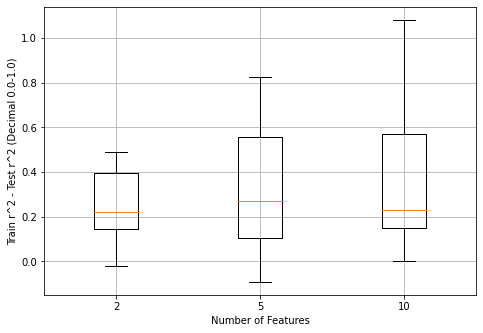

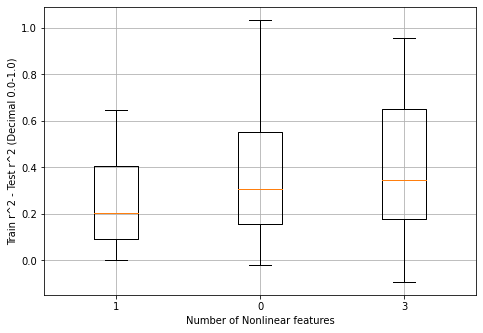

In [155]:
fig_bxplt_features, stats_features= fig_boxplot_r2differences(data_1_df, 'features', title='Number of Features')
fig_bxplt_nonlinear, stats_nonlinear = fig_boxplot_r2differences(data_1_df, 'nonlinear', title='Number of Nonlinear features')

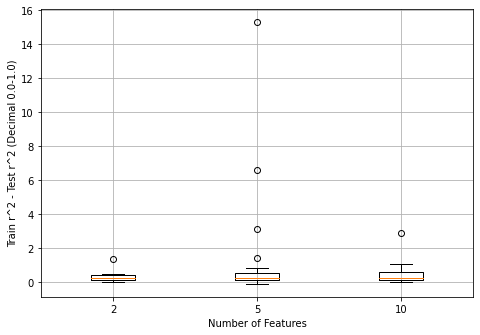

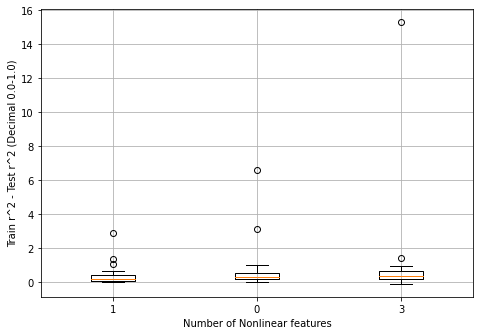

In [156]:
fig_bxplt_features, stats_features= fig_boxplot_r2differences(data_1_df, 'features', title='Number of Features', show_outliers=True)
fig_bxplt_nonlinear, stats_nonlinear = fig_boxplot_r2differences(data_1_df, 'nonlinear', title='Number of Nonlinear features', show_outliers=True)

In [20]:
# Test: saving matplotlib plots in pdfs
def fig_barh(ylabels, xvalues, title=''):
    # create a new figure
    fig = plt.figure()

    # plot to it
    yvalues = 0.1 + np.arange(len(ylabels))
    plt.barh(yvalues, xvalues, figure=fig)
    yvalues += 0.4
    plt.yticks(yvalues, ylabels, figure=fig)
    if title:
        plt.title(title, figure=fig)

    # return it
    return fig

def write_pdf(fname, figures):
    path = os.path.join(BASEPATH, 'main')
    doc = PdfPages(os.path.join(path, fname))
    for fig in figures:
        fig.savefig(doc, format='pdf')
    doc.close()

a = fig_barh(['a','b','c'], [1, 2, 3], 'Test #1')
b = fig_barh(['x','y','z'], [5, 3, 1], 'Test #2')
write_pdf('test.pdf', [a, b])

# Variable Importance